# Try to evaluate the mixing of the OT solution

In [1]:
from moscot.problems.cross_modality import TranslationProblem

import numpy as np

import matplotlib.pyplot as plt

import anndata as ad
import scanpy as sc
import jax
import os
import argparse
import gc

import pandas as pd
from sklearn.metrics import silhouette_score, adjusted_rand_score, r2_score
from sklearn.cluster import KMeans
from tqdm import tqdm

## Load the data

In [2]:
path = "/p/project1/hai_fzj_bda/koenig8/ot/data/"
adata_src = sc.read_h5ad(os.path.join(path, "adata_st.h5ad"))
adata_target = sc.read_h5ad(os.path.join(path, "adata_histo.h5ad"))
adata_target = adata_target[adata_target.obs.in_sample]
adata_src, adata_target

(AnnData object with n_obs × n_vars = 50000 × 50
     obs: 'patch_id', 'brain_area', 'patchsize', 'x_st', 'y_st', 'z_st', 'brain_section_label', 'section', 'test_set', 'val_set', 'train_set'
     uns: 'neighbors', 'umap'
     obsm: 'X_umap', 'brain_area_onehot', 'brain_area_similarities', 'pca_embedding', 'pca_plus_slides', 'pca_plus_slides_scaled'
     obsp: 'connectivities', 'distances',
 View of AnnData object with n_obs × n_vars = 50000 × 1536
     obs: 'image_id', 'patchsize', 'center_ccf', 'pixel_coord', 'distance', 'nearest_ST', 'nearest_cell_id', 'target_atlas_plate', 'distance_new', 'x', 'y', 'z', 'x_st', 'y_st', 'z_st', 'image_nr', 'brain_area', 'group', 'slice', 'in_sample', 'test_set', 'val_set', 'train_set'
     obsm: 'brain_area_onehot', 'brain_area_similarities', 'uni_embedding', 'uni_pca_95', 'uni_pca_plus_coords')

## First try it for the unfused setting

In [3]:
epsilon = 5e-3
seed = 42
source_key = "pca_embedding"
target_key = "uni_pca_95"
linear_term = None
alpha = 1.0
path = "/p/project1/hai_fzj_bda/koenig8/ot/mixing/unfused_basic"

def test_input_size(adata_src, adata_target, path, fractions = 1,  rank = -1):
    N = adata_src.shape[0]
    M = adata_target.shape[0]

    if fractions > 1:
        rng = np.random.default_rng(seed = seed)
        perm_N = rng.choice(N, size = N, replace = False)
        perm_M = rng.choice(M, size = M, replace = False)
        step_N = int(np.ceil(N/fractions))
        step_M = int(np.ceil(M/fractions))
        
        adatas_src = [adata_src[perm_N[i*step_N:(i+1)*step_N], :] for i in range(fractions)]
        adatas_target = [adata_target[perm_M[i*step_M:(i+1)*step_M], :] for i in range(fractions)]
    else:
        adatas_src = [adata_src, ]
        adatas_target = [adata_target, ]
        perm_N = np.arange(N)
        perm_M = np.arange(M)
        step_N = N,
        step_M = M
        
    print("Source Adatas:", [ad.shape for ad in adatas_src])
    print("Target Adatas:", [ad.shape for ad in adatas_target])

    for i in range(fractions):
        ad_src = adatas_src[i]
        ad_target = adatas_target[i]
        
        tp = TranslationProblem(adata_src=ad_src, adata_tgt=ad_target)
        tp = tp.prepare(src_attr=source_key, tgt_attr=target_key, joint_attr = linear_term)
        
        try:
            tp = tp.solve(alpha=alpha, epsilon=epsilon, rank = rank)
            tp.save(os.path.join(path, f"opt_transport{str(i)}.pkl"), overwrite = True)
            [x.delete() for x in jax.devices()[0].client.live_buffers()]
            
        except RuntimeError as e:
            if "out of memory" in str(e).lower():
                print(e)
                print("======================================FAILURE=========================================")
                return False  # OOM Error
            else:
                raise e  # Some other error
    # It worked :)
    if fractions > 1:
        np.save(os.path.join(path, f"permutation_source.npy"), perm_N)
        np.save(os.path.join(path, f"permutation_target.npy"), perm_M)
    return (adatas_src, adatas_target, N, M, step_N, step_M, perm_N, perm_M)

In [4]:
fractions = 0

max_fractions = 12

success = False
while (not success) and (fractions <= max_fractions):
    # Increase number of splits
    fractions += 1
    print(f"===========================================Fractions {fractions}==========================================")
    success = test_input_size(adata_src, adata_target, path, fractions)

print("Stopped at", fractions, "fractions")
src_adatas, target_adatas, N, M, step_N, step_M, perm_N, perm_M = success

===========================================Fractions 1==========================================
Source Adatas: [(50000, 50)]
Target Adatas: [(50000, 1536)]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(50000, 50000)].                                        


2025-04-28 09:45:58.994370: W external/xla/xla/hlo/transforms/simplifiers/hlo_rematerialization.cc:3021] Can't reduce memory use below 10.29GiB (11054937669 bytes) by rematerialization; only reduced to 56.22GiB (60366676698 bytes), down from 57.38GiB (61608401754 bytes) originally


RESOURCE_EXHAUSTED: Out of memory while trying to allocate 20604005072 bytes.
======================================FAILURE=========================================
===========================================Fractions 2==========================================
Source Adatas: [(25000, 50), (25000, 50)]
Target Adatas: [(25000, 1536), (25000, 1536)]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(25000, 25000)].                                        


2025-04-28 09:46:11.346587: W external/xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 19.19GiB (rounded to 20604005120)requested by op 
2025-04-28 09:46:11.346833: W external/xla/xla/tsl/framework/bfc_allocator.cc:512] ****************************************************************____________________________________
E0428 09:46:11.346915 2471020 pjrt_stream_executor_client.cc:3026] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 20604005072 bytes. [tf-allocator-allocation-error='']


INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(25000, 25000)].                                        
Stopped at 2 fractions


In [4]:
def switch_to_cpu():
    """Switch JAX to CPU mode."""
    [x.delete() for x in jax.devices()[0].client.live_buffers()]
    gc.collect()
    jax.config.update("jax_default_device", jax.devices("cpu")[0])

def switch_to_gpu():
    """Switch JAX to GPU mode."""
    gc.collect()
    jax.config.update("jax_default_device", jax.devices("gpu")[0])

In [5]:
## Use custom translation method
def _get_features(
            adata,
            attr,
        ):
    data = getattr(adata, attr["attr"])
    key = attr.get("key")
    return data if key is None else data[key]

In [6]:
def translate(adata_src, adata_target, src_adatas, target_adatas):
    print(f"{fractions} fractions, with combined shape {(N, M)}")

    tps = []
    for i in range(fractions):    
        tp = TranslationProblem(adata_src=src_adatas[i], adata_tgt=target_adatas[i])
        tp = tp.prepare(src_attr=source_key, tgt_attr=target_key, joint_attr=linear_term)
        tp = tp.load(os.path.join(path, f"opt_transport{str(i)}.pkl"))
        tps.append(tp)
    print("finished loading problems")
    
    transformations = []
    for p in range(fractions):
        print(f"======================================Fraction {p} ============================================")
        tp = tps[p]
        ad_target = target_adatas[p]
        src_attr = tp._src_attr
        tgt_attr = tp._tgt_attr
        features = _get_features(ad_target, attr=tgt_attr)
    
        batch_size = 30
        batch_transformed = []
        prop = tp["src", "tgt"]
        
        print("Performing", int(features.shape[1] / batch_size) + 1, "translation steps")
        [print("_", end='') for _ in range(int(features.shape[1] / batch_size) + 1)]
        print("")
        for i in range(0, features.shape[1], batch_size):
            print('■', end='')
            batch_transformed.append(prop.pull(
                features[:, i:i+batch_size], subset = None, normalize = False, scale_by_marginals = True
            ))
        print("")
        bt = np.concatenate(batch_transformed, axis=1)
        transformations.append(bt)
    
    ## Put it all together as one output array
    transformed = np.concatenate(transformations, axis=0)
    adata_src = adata_src.copy()
    adata_target = adata_target.copy()
    
    if fractions > 1:
        transformed = pd.DataFrame(transformed, index = perm_N).sort_index().to_numpy()
        adata_src.obs["fraction"] = -1
        adata_src.obs.iloc[perm_N, -1] = np.repeat(np.arange(fractions), step_N)[perm_N]
        adata_target.obs["fraction"] = -1
        adata_target.obs.iloc[perm_M, -1] = np.repeat(np.arange(fractions), step_M)[perm_M]
    
    adata_src.obsm["transformed"] = transformed
    np.save(os.path.join(path, "translated.npy"), transformed)
    
    adata_src.write_h5ad(os.path.join(path, "adata_src.h5ad"))
    adata_target.write_h5ad(os.path.join(path, "adata_target.h5ad"))
    return adata_src, adata_target
    

In [7]:
switch_to_cpu()
st_unfused, histo_unfused = translate(adata_src, adata_target, src_adatas, target_adatas)
st_unfused, histo_unfused

NameError: name 'src_adatas' is not defined

#### Look at the scores

In [10]:
mixing_unfused = silhouette_score(
    np.vstack((st_unfused.obsm["transformed"], histo_unfused.obsm[target_key])), 
    labels=np.concatenate((
        np.zeros(st_unfused.shape[0]).astype(bool), np.ones(histo_unfused.shape[0]).astype(bool)
    )), 
    random_state = seed
)
mixing_unfused

np.float32(0.051571615)

In [7]:
def translation_metric(adatas_src, adatas_target):
    predictions_T = []
    true_T = []
    tps = []
    for i in range(fractions):    
        tp = TranslationProblem(adata_src=adatas_src[i], adata_tgt=adatas_target[i])
        tp = tp.prepare(src_attr=source_key, tgt_attr=target_key, joint_attr=linear_term)
        tp = tp.load(os.path.join(path, f"opt_transport{str(i)}.pkl"))
        tps.append(tp)
    transitions = [tp[('src', 'tgt')].solution.transport_matrix.__array__() for tp in tps]
    
    for i in range(fractions):
        print(f"Fraction {i}")
        ad_st = adatas_src[i]
        ad_histo = adatas_target[i]
        
        histo_coordinates = ad_histo.obs.loc[:, ["x_st", "y_st", "z_st"]].to_numpy()
        spatial_coordinates = ad_st.obs.loc[:, ["x_st", "y_st", "z_st"]].to_numpy()
        T = transitions[i]
        true_T.append(spatial_coordinates)
    
        for j in tqdm(range(ad_st.shape[0])):
            t_j = T[j] / np.sum(T[j])
            t_j = np.repeat(t_j[:, None], 3, axis=1)
            prediction = np.sum(histo_coordinates * t_j, axis = 0)
            predictions_T.append(prediction)
    
    predictions_T = np.vstack(predictions_T)
    true_T = np.vstack(true_T)
    
    return r2_score(true_T, predictions_T)

In [17]:
coords_unfused = translation_metric(src_adatas, target_adatas)
coords_unfused

Fraction 0


100%|██████████| 25000/25000 [00:18<00:00, 1353.79it/s]


Fraction 1


100%|██████████| 25000/25000 [00:18<00:00, 1345.82it/s]


-0.16134399761538631

In [8]:
def ARI(src_embed, target_embed):
    embeddings = np.vstack((src_embed, target_embed))
    true_labels = np.array([0] * src_embed.shape[0] + [1] * target_embed.shape[0]).astype(bool)
    
    kmeans = KMeans(n_clusters=2, random_state=seed)
    predicted_labels = kmeans.fit_predict(embeddings)
    print("Finished kmeans:", np.unique(predicted_labels, return_counts=True))
    return adjusted_rand_score(true_labels, predicted_labels)

In [19]:
ari_unfused = ARI(st_unfused.obsm["transformed"], histo_unfused.obsm[target_key])
ari_unfused

Finished kmeans: (array([0, 1], dtype=int32), array([64437, 35563]))


0.0003964568502878072

# Repeat for the fused setting

In [17]:
epsilon = 5e-2
seed = 42
source_key = "pca_embedding"
target_key = "uni_pca_95"
linear_term = "brain_area_onehot"
alpha = 0.3
path = "/p/project1/hai_fzj_bda/koenig8/ot/mixing/fused_basic"

switch_to_gpu()

fractions = 3

max_fractions = 12

success = False
while (not success) and (fractions <= max_fractions):
    # Increase number of splits
    fractions += 1
    print(f"===========================================Fractions {fractions}==========================================")
    success = test_input_size(adata_src, adata_target, path, fractions)

print("Stopped at", fractions, "fractions")
src_adatas, target_adatas, N, M, step_N, step_M, perm_N, perm_M = success

===========================================Fractions 4==========================================
Source Adatas: [(12500, 50), (12500, 50), (12500, 50), (12500, 50)]
Target Adatas: [(12500, 1536), (12500, 1536), (12500, 1536), (12500, 1536)]
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(12500, 12500)].                                        
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
INFO     Solving `1` problems                                  

In [18]:
switch_to_cpu()
st_fused, histo_fused = translate(adata_src, adata_target, src_adatas, target_adatas)
st_fused, histo_fused

4 fractions, with combined shape (50000, 50000)
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
finished loading problem

(AnnData object with n_obs × n_vars = 50000 × 50
     obs: 'patch_id', 'brain_area', 'patchsize', 'x_st', 'y_st', 'z_st', 'brain_section_label', 'section', 'test_set', 'val_set', 'train_set', 'fraction'
     uns: 'neighbors', 'umap'
     obsm: 'X_umap', 'brain_area_onehot', 'brain_area_similarities', 'pca_embedding', 'pca_plus_slides', 'pca_plus_slides_scaled', 'transformed'
     obsp: 'connectivities', 'distances',
 AnnData object with n_obs × n_vars = 50000 × 1536
     obs: 'image_id', 'patchsize', 'center_ccf', 'pixel_coord', 'distance', 'nearest_ST', 'nearest_cell_id', 'target_atlas_plate', 'distance_new', 'x', 'y', 'z', 'x_st', 'y_st', 'z_st', 'image_nr', 'brain_area', 'group', 'slice', 'in_sample', 'test_set', 'val_set', 'train_set', 'fraction'
     obsm: 'brain_area_onehot', 'brain_area_similarities', 'uni_embedding', 'uni_pca_95', 'uni_pca_plus_coords')

In [19]:
coords_fused = translation_metric(src_adatas, target_adatas)
coords_fused

WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
Fraction 0


100%|██████████| 12500/12500 [00:04<00:00, 2623.05it/s]


Fraction 1


100%|██████████| 12500/12500 [00:04<00:00, 2620.48it/s]


Fraction 2


100%|██████████| 12500/12500 [00:04<00:00, 2628.94it/s]


Fraction 3


100%|██████████| 12500/12500 [00:04<00:00, 2621.36it/s]


0.20068003899092177

In [20]:
mixing_fused = silhouette_score(
    np.vstack((st_fused.obsm["transformed"], histo_fused.obsm[target_key])), 
    labels=np.concatenate((
        np.zeros(st_fused.shape[0]).astype(bool), np.ones(histo_fused.shape[0]).astype(bool)
    )), 
    random_state = seed
)
mixing_fused

np.float32(0.11829371)

In [21]:
ari_fused = ARI(st_fused.obsm["transformed"], histo_fused.obsm[target_key])
ari_fused

Finished kmeans: (array([0, 1], dtype=int32), array([79223, 20777]))


0.00820545429486007

==> The R² is higher than ever before at 20 percent... Let's check if we can increase it even further by increasing the epsilon

## Smaller epsilon

In [8]:
os.makedirs("/p/project1/hai_fzj_bda/koenig8/ot/mixing/fused_low_epsilon")

In [9]:
results = []
epsilons = []
for epsilon in np.linspace(5e-2, 0.5, 10):
    seed = 42
    source_key = "pca_embedding"
    target_key = "uni_pca_95"
    linear_term = "brain_area_onehot"
    alpha = 0.3
    path = "/p/project1/hai_fzj_bda/koenig8/ot/mixing/fused_low_epsilon"
    
    switch_to_gpu()
    
    fractions = 4    
    success = test_input_size(adata_src, adata_target, path, fractions)
    src_adatas, target_adatas, N, M, step_N, step_M, perm_N, perm_M = success

    switch_to_cpu()

    coords = translation_metric(src_adatas, target_adatas)
    print(epsilon, coords)
    results.append(coords)
    epsilons.append(epsilon)

Source Adatas: [(12500, 50), (12500, 50), (12500, 50), (12500, 50)]
Target Adatas: [(12500, 1536), (12500, 1536), (12500, 1536), (12500, 1536)]
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(12500, 12500)].                                        
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='pr

100%|██████████| 12500/12500 [00:04<00:00, 2636.69it/s]


Fraction 1


100%|██████████| 12500/12500 [00:04<00:00, 2630.46it/s]


Fraction 2


100%|██████████| 12500/12500 [00:04<00:00, 2635.04it/s]


Fraction 3


100%|██████████| 12500/12500 [00:04<00:00, 2629.96it/s]


0.05 0.20066414485135167
Source Adatas: [(12500, 50), (12500, 50), (12500, 50), (12500, 50)]
Target Adatas: [(12500, 1536), (12500, 1536), (12500, 1536), (12500, 1536)]
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(12500, 12500)].                                        
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
INFO     Solving `1` problems                                                                                      
INFO     Solving pr

100%|██████████| 12500/12500 [00:04<00:00, 2639.92it/s]


Fraction 1


100%|██████████| 12500/12500 [00:04<00:00, 2645.84it/s]


Fraction 2


100%|██████████| 12500/12500 [00:04<00:00, 2643.61it/s]


Fraction 3


100%|██████████| 12500/12500 [00:04<00:00, 2618.36it/s]


0.1 0.205859984270221
Source Adatas: [(12500, 50), (12500, 50), (12500, 50), (12500, 50)]
Target Adatas: [(12500, 1536), (12500, 1536), (12500, 1536), (12500, 1536)]
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(12500, 12500)].                                        
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
INFO     Solving `1` problems                                                                                      
INFO     Solving probl

100%|██████████| 12500/12500 [00:04<00:00, 2630.74it/s]


Fraction 1


100%|██████████| 12500/12500 [00:04<00:00, 2643.23it/s]


Fraction 2


100%|██████████| 12500/12500 [00:04<00:00, 2643.70it/s]


Fraction 3


100%|██████████| 12500/12500 [00:04<00:00, 2644.19it/s]


0.15000000000000002 0.20072766991020385
Source Adatas: [(12500, 50), (12500, 50), (12500, 50), (12500, 50)]
Target Adatas: [(12500, 1536), (12500, 1536), (12500, 1536), (12500, 1536)]
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(12500, 12500)].                                        
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
INFO     Solving `1` problems                                                                                      
INFO

100%|██████████| 12500/12500 [00:04<00:00, 2635.78it/s]


Fraction 1


100%|██████████| 12500/12500 [00:04<00:00, 2632.09it/s]


Fraction 2


100%|██████████| 12500/12500 [00:04<00:00, 2638.07it/s]


Fraction 3


100%|██████████| 12500/12500 [00:04<00:00, 2610.94it/s]


0.2 0.19673434690770628
Source Adatas: [(12500, 50), (12500, 50), (12500, 50), (12500, 50)]
Target Adatas: [(12500, 1536), (12500, 1536), (12500, 1536), (12500, 1536)]
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(12500, 12500)].                                        
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
INFO     Solving `1` problems                                                                                      
INFO     Solving pro

100%|██████████| 12500/12500 [00:04<00:00, 2657.52it/s]


Fraction 1


100%|██████████| 12500/12500 [00:04<00:00, 2657.79it/s]


Fraction 2


100%|██████████| 12500/12500 [00:04<00:00, 2654.22it/s]


Fraction 3


100%|██████████| 12500/12500 [00:04<00:00, 2657.08it/s]


0.25 0.1940585134215287
Source Adatas: [(12500, 50), (12500, 50), (12500, 50), (12500, 50)]
Target Adatas: [(12500, 1536), (12500, 1536), (12500, 1536), (12500, 1536)]
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(12500, 12500)].                                        
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
INFO     Solving `1` problems                                                                                      
INFO     Solving pro

100%|██████████| 12500/12500 [00:04<00:00, 2649.15it/s]


Fraction 1


100%|██████████| 12500/12500 [00:04<00:00, 2642.21it/s]


Fraction 2


100%|██████████| 12500/12500 [00:04<00:00, 2641.26it/s]


Fraction 3


100%|██████████| 12500/12500 [00:04<00:00, 2647.46it/s]


0.3 0.1919899127889192
Source Adatas: [(12500, 50), (12500, 50), (12500, 50), (12500, 50)]
Target Adatas: [(12500, 1536), (12500, 1536), (12500, 1536), (12500, 1536)]
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(12500, 12500)].                                        
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
INFO     Solving `1` problems                                                                                      
INFO     Solving prob

100%|██████████| 12500/12500 [00:04<00:00, 2639.64it/s]


Fraction 1


100%|██████████| 12500/12500 [00:04<00:00, 2645.48it/s]


Fraction 2


100%|██████████| 12500/12500 [00:04<00:00, 2641.20it/s]


Fraction 3


100%|██████████| 12500/12500 [00:04<00:00, 2612.28it/s]


0.35000000000000003 0.19051564932714213
Source Adatas: [(12500, 50), (12500, 50), (12500, 50), (12500, 50)]
Target Adatas: [(12500, 1536), (12500, 1536), (12500, 1536), (12500, 1536)]
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(12500, 12500)].                                        
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
INFO     Solving `1` problems                                                                                      
INFO

100%|██████████| 12500/12500 [00:04<00:00, 2647.65it/s]


Fraction 1


100%|██████████| 12500/12500 [00:04<00:00, 2647.91it/s]


Fraction 2


100%|██████████| 12500/12500 [00:04<00:00, 2644.11it/s]


Fraction 3


100%|██████████| 12500/12500 [00:04<00:00, 2628.53it/s]


0.4 0.189369022933232
Source Adatas: [(12500, 50), (12500, 50), (12500, 50), (12500, 50)]
Target Adatas: [(12500, 1536), (12500, 1536), (12500, 1536), (12500, 1536)]
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(12500, 12500)].                                        
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
INFO     Solving `1` problems                                                                                      
INFO     Solving probl

100%|██████████| 12500/12500 [00:04<00:00, 2640.64it/s]


Fraction 1


100%|██████████| 12500/12500 [00:04<00:00, 2643.64it/s]


Fraction 2


100%|██████████| 12500/12500 [00:04<00:00, 2639.87it/s]


Fraction 3


100%|██████████| 12500/12500 [00:04<00:00, 2613.43it/s]


0.45 0.18833678258152844
Source Adatas: [(12500, 50), (12500, 50), (12500, 50), (12500, 50)]
Target Adatas: [(12500, 1536), (12500, 1536), (12500, 1536), (12500, 1536)]
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(12500, 12500)].                                        
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
INFO     Solving `1` problems                                                                                      
INFO     Solving pr

100%|██████████| 12500/12500 [00:04<00:00, 2627.68it/s]


Fraction 1


100%|██████████| 12500/12500 [00:04<00:00, 2651.34it/s]


Fraction 2


100%|██████████| 12500/12500 [00:04<00:00, 2653.03it/s]


Fraction 3


100%|██████████| 12500/12500 [00:04<00:00, 2651.71it/s]


0.5 0.18737137512697224


<Axes: xlabel='Epsilon'>

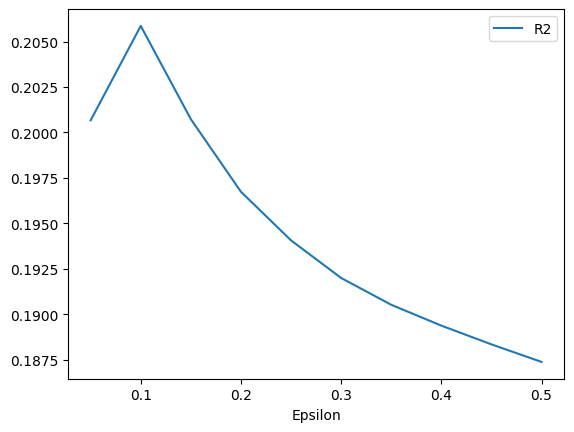

In [12]:
pd.DataFrame(np.array([epsilons, results]).T, columns = ["Epsilon", "R2"]).plot.line(x="Epsilon", y = "R2")

#### Seems that 0.1 is the sweet spot for epsilon. Try again using the new embedding keys

In [16]:
epsilon = 0.1
seed = 42
source_key = "pca_plus_slides_scaled"
target_key = "uni_pca_plus_coords"
linear_term = "brain_area_similarities"
alpha = 0.3
path = "/p/project1/hai_fzj_bda/koenig8/ot/mixing/fused_extended"
os.makedirs(path)

switch_to_gpu()

fractions = 4
success = test_input_size(adata_src, adata_target, path, fractions)

src_adatas, target_adatas, N, M, step_N, step_M, perm_N, perm_M = success

Source Adatas: [(12500, 50), (12500, 50), (12500, 50), (12500, 50)]
Target Adatas: [(12500, 1536), (12500, 1536), (12500, 1536), (12500, 1536)]
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(12500, 12500)].                                        
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(12500, 12500)].                                        
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(12500, 12500)].                                        
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='pr

In [17]:
switch_to_cpu()
coords = translation_metric(src_adatas, target_adatas)
coords

Fraction 0


100%|██████████| 12500/12500 [00:04<00:00, 2644.37it/s]


Fraction 1


100%|██████████| 12500/12500 [00:04<00:00, 2647.63it/s]


Fraction 2


100%|██████████| 12500/12500 [00:04<00:00, 2629.35it/s]


Fraction 3


100%|██████████| 12500/12500 [00:04<00:00, 2615.58it/s]


0.18462004776854105

==> No  improvement